In [30]:
import random
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import argparse
import logging
from collections import deque


In [31]:
MAX_SPEED = 10  # Fixed max speed
HEALTH_INCREASE = 20
LOW_HEALTH_LOSS = 0.5
HEALTH_LOSS_MULTIPLIER = 0.75
STATE_SIZE = 4
FOOD_REWARD = 1
SURVIVAL_REWARD = 0.1
PROBABILITY  = 0.4
MAX_ITERATIONS = 1000

In [32]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.99  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.learning_rate = 0.001
        self.target_update_tau = 0.01
        self.model = self._build_model()
        self.target_model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, input_dim=self.state_size, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=self.learning_rate))
        return model
    
    def soft_update_target_model(self):
        main_weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        
        new_weights = []
        for mw, tw in zip(main_weights, target_weights):
            new_w = self.target_update_tau * mw + (1 - self.target_update_tau) * tw
            new_weights.append(new_w)
        
        self.target_model.set_weights(new_weights)


    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        if len(self.memory) > 500000:
            self.memory = self.memory[-500000:]

        minibatch = random.sample(self.memory, batch_size)

        states = np.array([x[0] for x in minibatch])
        actions = np.array([x[1] for x in minibatch])
        rewards = np.array([x[2] for x in minibatch])
        next_states = np.array([x[3] for x in minibatch])
        dones = np.array([x[4] for x in minibatch])

        states = np.squeeze(np.array(states))
        next_states = np.squeeze(np.array(next_states))

        targets = self.target_model.predict(states, verbose=0)
        next_state_targets = self.target_model.predict(next_states, verbose=0)

        targets[np.arange(batch_size), actions] = rewards + self.gamma * np.max(next_state_targets, axis=1) * (1 - dones)

        self.model.fit(states, targets, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save(self, filename):
        self.model.save(filename)

    @classmethod
    def load(cls, filename, state_size, action_size):
        agent = cls(state_size, action_size)
        agent.model = tf.keras.models.load_model(filename)
        agent.target_model = tf.keras.models.load_model(filename)
        return agent

In [33]:
class VirtualWorld:
    def __init__(self, max_speed):
        self.max_speed = max_speed
        self.food_expiration_time = 5
        self.no_food_rate = 5
        self.food_quality_range = (0.5, 1.5)
        self.food_degradation_rate = 0.05
        self.reset()

    def reset(self):
        self.p = PROBABILITY
        self.agent_position = 0
        self.agent_speed = 0
        self.agent_health = 100
        self.food_position = self.generate_food_position()
        self.food_quality = random.uniform(*self.food_quality_range)
        self.food_timer = 0
        self.iteration = 0
        self.no_food_timer = 0
        return np.array([[self.agent_position, self.agent_health, 
                          self.food_position, self.food_quality]])

    def generate_food_position(self):
        return random.randint(5, 20)

    def step(self, action):
        self.agent_speed = action
        self.agent_position += self.agent_speed
        self.iteration += 1

        # Calculate health loss
        if self.agent_speed == 0:
            health_loss = LOW_HEALTH_LOSS
        else:
            health_loss = self.agent_speed * HEALTH_LOSS_MULTIPLIER

        self.agent_health -= health_loss

        reward = SURVIVAL_REWARD
        done = False

        if self.food_position >= 0:
            self.food_timer += 1
            self.no_food_timer = 0
            self.food_position -= action
            self.food_quality = max(self.food_quality_range[0], 
                                    self.food_quality - self.food_degradation_rate)

            if self.food_position <= 0:
                self.agent_health = min(self.agent_health + HEALTH_INCREASE * self.food_quality, 100)
                reward += FOOD_REWARD * self.food_quality
                if random.random() >= self.p:
                    self.food_position = -1
                else:
                    self.food_timer = 0
                    self.food_position = self.generate_food_position()
                    self.food_quality = random.uniform(*self.food_quality_range)
            elif self.food_timer >= self.food_expiration_time:
                if random.random() >= self.p:
                    self.food_position = -1
                else:
                    self.food_timer = 0
                    self.food_position = self.generate_food_position()
                    self.food_quality = random.uniform(*self.food_quality_range)
        else:
            self.no_food_timer += 1
            self.food_timer = 0
            if self.no_food_timer >= self.no_food_rate:
                self.food_position = self.generate_food_position()
                self.food_quality = random.uniform(*self.food_quality_range)

        # Check for death or max iterations
        if self.agent_health <= 0 or self.iteration >= MAX_ITERATIONS:
            done = True

        return np.array([[self.agent_position, self.agent_health, 
                          self.food_position, self.food_quality]]), reward, done


In [34]:
def run_experiment(max_speed=MAX_SPEED, num_episodes=500):
    global PROBABILITY
    state_size = STATE_SIZE
    action_size = max_speed + 1
    world = VirtualWorld(max_speed=max_speed)
    agent = DQNAgent(state_size, action_size)

    total_actions = []
    rewards = []
    epsilon_values = []
    goals_reached = 0
    avg_rewards = deque(maxlen=100)
    
    # Set up logging
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
    for episode in tqdm(range(num_episodes), desc="Training"):
        state = world.reset()
        state = np.reshape(state, [1, state_size])
        episode_actions = []
        episode_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            episode_actions.append(action)
            next_state, reward, done = world.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        total_actions.append(np.mean(episode_actions))
        rewards.append(episode_reward)
        avg_rewards.append(episode_reward)
        epsilon_values.append(agent.epsilon)
        
        if len(agent.memory) > 64:
            agent.replay(64)
            agent.soft_update_target_model()
        
        # Log progress every 10 episodes
        if episode % 100 == 0:
            logging.info(f"Episode {episode}/{num_episodes}, Avg Reward: {np.mean(avg_rewards):.2f}, "
                         f"Epsilon: {agent.epsilon:.2f}, Probability: {PROBABILITY:.2f}")
            
    return agent, rewards

def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.title('Average Reward per Episode')
    plt.grid(True)
    plt.show()

def animate_episode(agent, world):
    state = world.reset()
    state = np.reshape(state, [1, STATE_SIZE])
    t1, t2 = 30, 45
    episode_states = []
    speeds = []
    done = False
    curr_time = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done = world.step(action)
        next_state = np.reshape(next_state, [1, STATE_SIZE])
        state = next_state
        episode_states.append(state.flatten())
        speeds.append(action)
        curr_time += 1
    
    # print why the episode ended
    if episode_states[-1][1] >= 0:
        print("Goal Reached!")
    else:
        print("Agent Died!")

    fig, ax = plt.subplots()
    ax.set_xlim(0, len(speeds))
    ax.set_ylim(0, max(max(speeds), 200))  # Adjust y-axis to fit both speed and health
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Speed / Health')
    ax.set_title('Agent Speed and Health Over Time')

    speed_line, = ax.plot([], [], lw=2, label='Agent Speed')
    health_line, = ax.plot([], [], lw=2, label='Agent Health', color='red')
    # food_dot, = ax.plot([], [], 'go', label='Food Position')

    # plot line at x = t1 and x = t2
    ax.axvline(x=t1, color='black', linestyle='--')
    ax.axvline(x=t2, color='black', linestyle='--')

    def init():
        speed_line.set_data([], [])
        health_line.set_data([], [])
        # food_dot.set_data([], [])
        return speed_line, health_line, # food_dot

    def animate(i):
        state = episode_states[i]
        speed_data = speeds[:i+1]
        healths = [s[1] for s in episode_states[:i+1]]
        food_position = state[2]
        
        speed_line.set_data(range(i+1), speed_data)
        health_line.set_data(range(i+1), healths)
        # food_dot.set_data(i, food_position)  # Food dot at current step
        return speed_line, health_line, # food_dot

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(episode_states), interval=200, blit=True)
    plt.legend()
    plt.show()
    ani.save('episode_animation.gif', writer='pillow', fps=5)


In [35]:
# Load the agent
agent = DQNAgent.load('saved_models/trained_agent4.keras', STATE_SIZE, MAX_SPEED + 1)
agent.epsilon = 0  # Set epsilon to 0 to always choose the best action
print("Agent loaded successfully!")

Agent loaded successfully!


Agent Died!


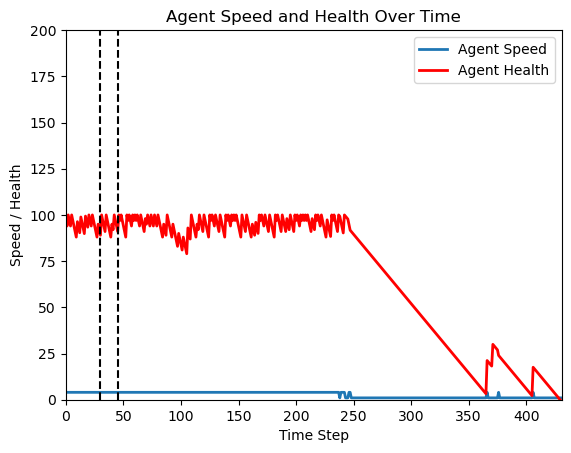

In [37]:
# Animate a single episode with the trained agent
world = VirtualWorld(MAX_SPEED)
animate_episode(agent, world)